In [1]:
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensordict import MemoryMappedTensor
import shutil

from world_machine.layers.attention import MultiHeadSelfAttention, MultiHeadAttention
from world_machine import WorldMachine
from world_machine_experiments.toy1d import Dimensions
from world_machine.train.stages  import TrainStage
from world_machine.train.scheduler import UniformScheduler
from world_machine.train import Trainer
from world_machine.train.stages import SensorialMasker, StateManager, LossManager

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

In [4]:
batch_size = 32

In [5]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base
from hamilton import driver


d = driver.Builder().with_modules(base, shared).build()

inputs = {"sequence_length": 1000,
                       "n_sequence": 10000,
                       "context_size": 200,
                       "batch_size": batch_size,
                       "learning_rate": 5e-4,
                       "weight_decay": 5e-5,
                       "accumulation_steps": 1,
                       "state_dimensions": [0],
                       "device": device,
                       "state_control": "periodic",
                       "seed":[0,42],
                       "train_mse":True,
                       "train_sdtw":False,
                       "sensorial_train_losses": [Dimensions.MEASUREMENT]
                       }

outputs = d.execute(["toy1d_dataloaders", "toy1d_criterion_set"], inputs=inputs)

In [6]:
criterion_set = outputs["toy1d_criterion_set"]

In [7]:
seq_len = 200
state_size = 128


In [8]:
from world_machine.train.stages import StateManager, PrepareModel
from world_machine.train import DatasetPassMode

sm = StateManager()
pm = PrepareModel()

np_generator = np.random.default_rng(0)
torch_generator = torch.Generator(device=device)
torch_generator.manual_seed(0)

for stage in [sm, pm]:
    stage.set_generators(np_generator, torch_generator)

In [9]:
train_loader = outputs["toy1d_dataloaders"]["train"]
val_loader = outputs["toy1d_dataloaders"]["val"]

In [10]:
recompute = False

if recompute:

    pm.pre_batch(model, DatasetPassMode.MODE_EVALUATE, None, None, None, None, None)

    for split in ["train", "val"]:
        dataloader = outputs["toy1d_dataloaders"][split]
        dataset = dataloader.dataset
        for item in tqdm.tqdm(dataloader, desc="State Generation"):
            item = item.to(device)
            
            segments = [item]
            sm.pre_segment(segments, None, batch_size, seq_len, 0, device, state_size, None)

            sensorial_data = item["inputs"]
            state = item["inputs"]["state"]
            logits = model.inference(state=state, sensorial_data=sensorial_data)

            #logits.batch_size = [32]
            item["logits"] = logits

            segments = [item]
            sm.post_segment(segments, None, dataset, 0, None, DatasetPassMode.MODE_EVALUATE, device, None)

    pm.post_batch(model, None, None, None)

else:
    states_shape = [batch_size, seq_len, state_size]

    shutil.copyfile("TempStates_Toy1dDataset_0.bin", "TempStates_Toy1dDataset_0_copy.bin")
    shutil.copyfile("TempStates_Toy1dDataset_1.bin", "TempStates_Toy1dDataset_1_copy.bin")

    states_shape[0] = train_loader.dataset._size
    train_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_0_copy.bin", dtype=torch.float32, shape=states_shape)

    states_shape[0] = val_loader.dataset._size
    val_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_1_copy.bin", dtype=torch.float32, shape=states_shape)

train_loader.dataset.persist_states = True
val_loader.dataset.persist_states = True

In [11]:
from torch.optim import AdamW

from world_machine_experiments.toy1d.base import toy1d_model_training_info
from world_machine_experiments.toy1d.base  import toy1d_metrics, toy1d_metrics_sample_logits, toy1d_metrics_sample_plots, save_toy1d_metrics_sample_plots

In [12]:
dataloaders =  outputs["toy1d_dataloaders"]

In [13]:
del criterion_set.criterions["state_decoded"]["0.1sdtw"]
del criterion_set.criterions["measurement"]["0.1sdtw"]

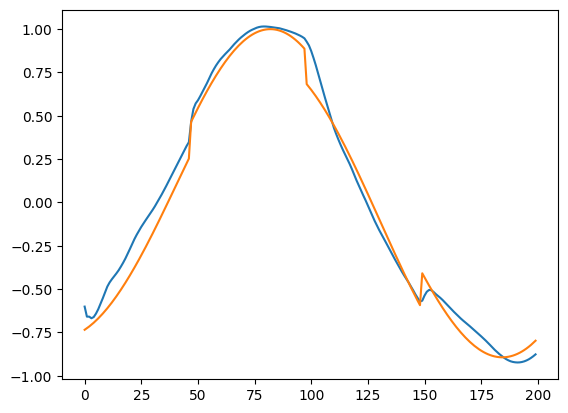

In [14]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

item = next(iter(train_loader))

item = item.to(device)

with torch.no_grad():
    logits = model(item["inputs"]["state"], sensorial_data=item["inputs"])

index = 0
plt.plot(logits["state_decoded"][index,:,0].cpu())
plt.plot(item["inputs"]["state_decoded"][index,:,0].cpu())

In [33]:
from tensordict import TensorDict
from world_machine.train.stages import StateSaveMethod
from torch.nn import Module
from world_machine.data import WorldMachineDataset

class StateManager(TrainStage):
    def __init__(self,
                 stable_state_epochs: int = 1,
                 check_input_masks: bool = False,
                 state_save_method: StateSaveMethod = StateSaveMethod.REPLACE,
                 check_local_mode:bool = False):
        super().__init__(1)

        self._stable_state_epochs = stable_state_epochs
        self._check_input_masks = check_input_masks
        self._state_save_method = state_save_method
        self._check_local_mode = check_local_mode

    def pre_segment(self, itens: list[TensorDict], losses: dict, batch_size: int,
                    seq_len: int, epoch_index: int, device: torch.device, state_size: int, mode: DatasetPassMode, model: WorldMachine) -> None:

        if epoch_index == 0 and "state" not in itens[0]["inputs"]:
            for item in itens:
                seq_len = item["inputs"][next(
                    iter(item["inputs"].keys()))].shape[1]

                state = torch.rand(
                    (batch_size, seq_len, state_size), device=device, generator=self.torch_generator)
                state = (2*state)-1

                state[:, 0, :] = 0

                item["inputs"]["state"] = state

    def post_segment(self, itens: list[TensorDict], losses: dict, dataset: WorldMachineDataset, epoch_index: int,
                     criterions: dict[str, dict[str, Module]], mode: DatasetPassMode,
                     device: torch.device, train_criterions: dict[str, dict[str, float]]) -> None:

        batch_size = itens[0].batch_size[0]

        for item in itens:
            state_input = item["inputs"]["state"]
            state_next = item["logits"]["state"]

            state_current = torch.roll(state_next, 1, 1)
            state_current[:, 0] = state_input[:, 0]

            if (mode == DatasetPassMode.MODE_TRAIN and 
                "input_masks" in item and 
                 (self._check_input_masks or self._check_local_mode)):
                
                seq_len = item["inputs"][next(
                        iter(item["inputs"].keys()))].shape[1]
                
                mask = torch.zeros((batch_size, seq_len),
                                   dtype=bool, device=device)

                if self._check_input_masks:
                    input_masks = item["input_masks"]
                    for dim in input_masks.keys():
                        mask = torch.bitwise_or(mask, input_masks[dim])
                
                if self._check_local_mode:
                    for module in model.modules():
                        if isinstance(module, MultiHeadAttention) and module.local_only:
                            mask.fill_(False)
                            break

                state_current[torch.bitwise_not(
                    mask)] = state_input[torch.bitwise_not(mask)]

            # REPLACE = do nothing
            if self._state_save_method == StateSaveMethod.MEAN:
                state_current = (state_current+state_input)/2

            indexes = item["index"]

            if (epoch_index % self._stable_state_epochs == 0):
                dataset.set_state(indexes, state_current)


In [93]:


class SetLocal(TrainStage):
    def __init__(self, local_chance:float = 0.5):
        super().__init__(3)

        self._local_chance = local_chance

    def pre_segment(self, itens, losses, batch_size, seq_len, epoch_index, device, state_size, mode, model):
        
        local = self.np_generator.random() <= self._local_chance
        for module in model.modules():
            if isinstance(module, MultiHeadAttention):
                module.local_only = local#self.np_generator.random() <= self._local_chance
                #module.requires_grad_(not module.local_only)

    def post_train(self, model, criterions, train_criterions):
        for module in model.modules():
            if isinstance(module, MultiHeadAttention):
                module.local_only = False
                #module.requires_grad_(True)


In [94]:
from world_machine.train.stages import StateManager


In [105]:



model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

n_epoch = 20

optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=5e-7)

model.to(device)

stages = []

stages.append(SensorialMasker(UniformScheduler(0, 1, n_epoch)))
stages.append(StateManager(state_save_method=StateSaveMethod.MEAN))
stages.append(LossManager(multiply_target_masks=False))
stages.append(SetLocal(0.25))

trainer = Trainer(criterion_set, stages, seed=0)

history = trainer(model, dataloaders, optimizer, n_epoch)

100%|██████████| 250/250 [00:13<00:00, 19.21it/s]


VAL Epoch [0/20],             Loss: 0.0261


100%|██████████| 750/750 [00:40<00:00, 18.65it/s]


Epoch [1/20],             Loss: 0.0291, Elapsed Time: 40.27 sec


100%|██████████| 250/250 [00:13<00:00, 19.22it/s]


VAL Epoch [1/20],             Loss: 0.0213


100%|██████████| 750/750 [00:40<00:00, 18.54it/s]


Epoch [2/20],             Loss: 0.0262, Elapsed Time: 40.51 sec


100%|██████████| 250/250 [00:12<00:00, 19.25it/s]


VAL Epoch [2/20],             Loss: 0.0196


100%|██████████| 750/750 [00:39<00:00, 18.76it/s]


Epoch [3/20],             Loss: 0.0252, Elapsed Time: 40.05 sec


100%|██████████| 250/250 [00:12<00:00, 19.37it/s]


VAL Epoch [3/20],             Loss: 0.0189


100%|██████████| 750/750 [00:40<00:00, 18.63it/s]


Epoch [4/20],             Loss: 0.0246, Elapsed Time: 40.31 sec


100%|██████████| 250/250 [00:13<00:00, 19.12it/s]


VAL Epoch [4/20],             Loss: 0.0186


100%|██████████| 750/750 [00:43<00:00, 17.30it/s]


Epoch [5/20],             Loss: 0.0237, Elapsed Time: 43.40 sec


100%|██████████| 250/250 [00:13<00:00, 18.94it/s]


VAL Epoch [5/20],             Loss: 0.0179


100%|██████████| 750/750 [00:40<00:00, 18.64it/s]


Epoch [6/20],             Loss: 0.0230, Elapsed Time: 40.30 sec


100%|██████████| 250/250 [00:13<00:00, 19.18it/s]


VAL Epoch [6/20],             Loss: 0.0176


100%|██████████| 750/750 [00:39<00:00, 18.85it/s]


Epoch [7/20],             Loss: 0.0228, Elapsed Time: 39.85 sec


100%|██████████| 250/250 [00:12<00:00, 19.67it/s]


VAL Epoch [7/20],             Loss: 0.0174


100%|██████████| 750/750 [00:39<00:00, 18.98it/s]


Epoch [8/20],             Loss: 0.0220, Elapsed Time: 39.56 sec


100%|██████████| 250/250 [00:12<00:00, 19.43it/s]


VAL Epoch [8/20],             Loss: 0.0174


100%|██████████| 750/750 [00:39<00:00, 19.03it/s]


Epoch [9/20],             Loss: 0.0219, Elapsed Time: 39.47 sec


100%|██████████| 250/250 [00:12<00:00, 19.76it/s]


VAL Epoch [9/20],             Loss: 0.0167


100%|██████████| 750/750 [00:39<00:00, 18.76it/s]


Epoch [10/20],             Loss: 0.0217, Elapsed Time: 40.05 sec


100%|██████████| 250/250 [00:13<00:00, 19.10it/s]


VAL Epoch [10/20],             Loss: 0.0167


100%|██████████| 750/750 [00:42<00:00, 17.68it/s]


Epoch [11/20],             Loss: 0.0215, Elapsed Time: 42.48 sec


100%|██████████| 250/250 [00:12<00:00, 19.56it/s]


VAL Epoch [11/20],             Loss: 0.0165


100%|██████████| 750/750 [00:39<00:00, 18.82it/s]


Epoch [12/20],             Loss: 0.0210, Elapsed Time: 39.93 sec


100%|██████████| 250/250 [00:12<00:00, 19.43it/s]


VAL Epoch [12/20],             Loss: 0.0164


100%|██████████| 750/750 [00:39<00:00, 19.02it/s]


Epoch [13/20],             Loss: 0.0209, Elapsed Time: 39.48 sec


100%|██████████| 250/250 [00:12<00:00, 20.36it/s]


VAL Epoch [13/20],             Loss: 0.0165


100%|██████████| 750/750 [00:39<00:00, 19.13it/s]


Epoch [14/20],             Loss: 0.0206, Elapsed Time: 39.27 sec


100%|██████████| 250/250 [00:12<00:00, 20.65it/s]


VAL Epoch [14/20],             Loss: 0.0163


100%|██████████| 750/750 [00:38<00:00, 19.62it/s]


Epoch [15/20],             Loss: 0.0203, Elapsed Time: 38.29 sec


100%|██████████| 250/250 [00:12<00:00, 20.41it/s]


VAL Epoch [15/20],             Loss: 0.0162


100%|██████████| 750/750 [00:39<00:00, 19.08it/s]


Epoch [16/20],             Loss: 0.0202, Elapsed Time: 39.37 sec


100%|██████████| 250/250 [00:13<00:00, 18.70it/s]


VAL Epoch [16/20],             Loss: 0.0162


100%|██████████| 750/750 [00:40<00:00, 18.73it/s]


Epoch [17/20],             Loss: 0.0203, Elapsed Time: 40.10 sec


100%|██████████| 250/250 [00:13<00:00, 19.21it/s]


VAL Epoch [17/20],             Loss: 0.0162


100%|██████████| 750/750 [00:40<00:00, 18.57it/s]


Epoch [18/20],             Loss: 0.0199, Elapsed Time: 40.44 sec


100%|██████████| 250/250 [00:12<00:00, 19.24it/s]


VAL Epoch [18/20],             Loss: 0.0161


100%|██████████| 750/750 [00:40<00:00, 18.56it/s]


Epoch [19/20],             Loss: 0.0198, Elapsed Time: 40.47 sec


100%|██████████| 250/250 [00:13<00:00, 18.38it/s]


VAL Epoch [19/20],             Loss: 0.0159


100%|██████████| 750/750 [00:40<00:00, 18.56it/s]


Epoch [20/20],             Loss: 0.0195, Elapsed Time: 40.46 sec


100%|██████████| 250/250 [00:12<00:00, 19.43it/s]

VAL Epoch [20/20],             Loss: 0.0158


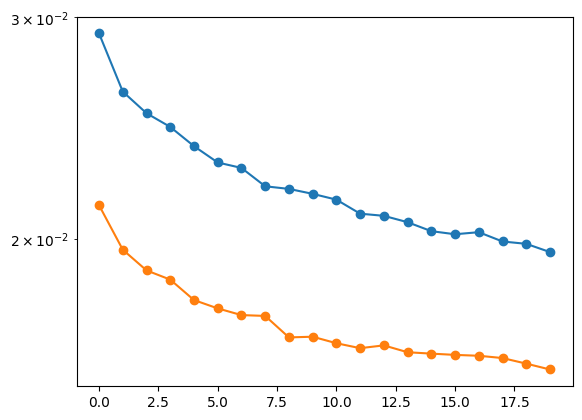

In [106]:
plt.plot(history["optimizer_loss_train"], "o-")
plt.plot(history["optimizer_loss_val"], "o-")

plt.yscale("log")

plt.show()

In [107]:
#metrics = toy1d_metrics(model, outputs["dataloaders"], criterion_set)

sample_logits = toy1d_metrics_sample_logits(model, dataloaders, criterion_set)


Metrics Generation: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


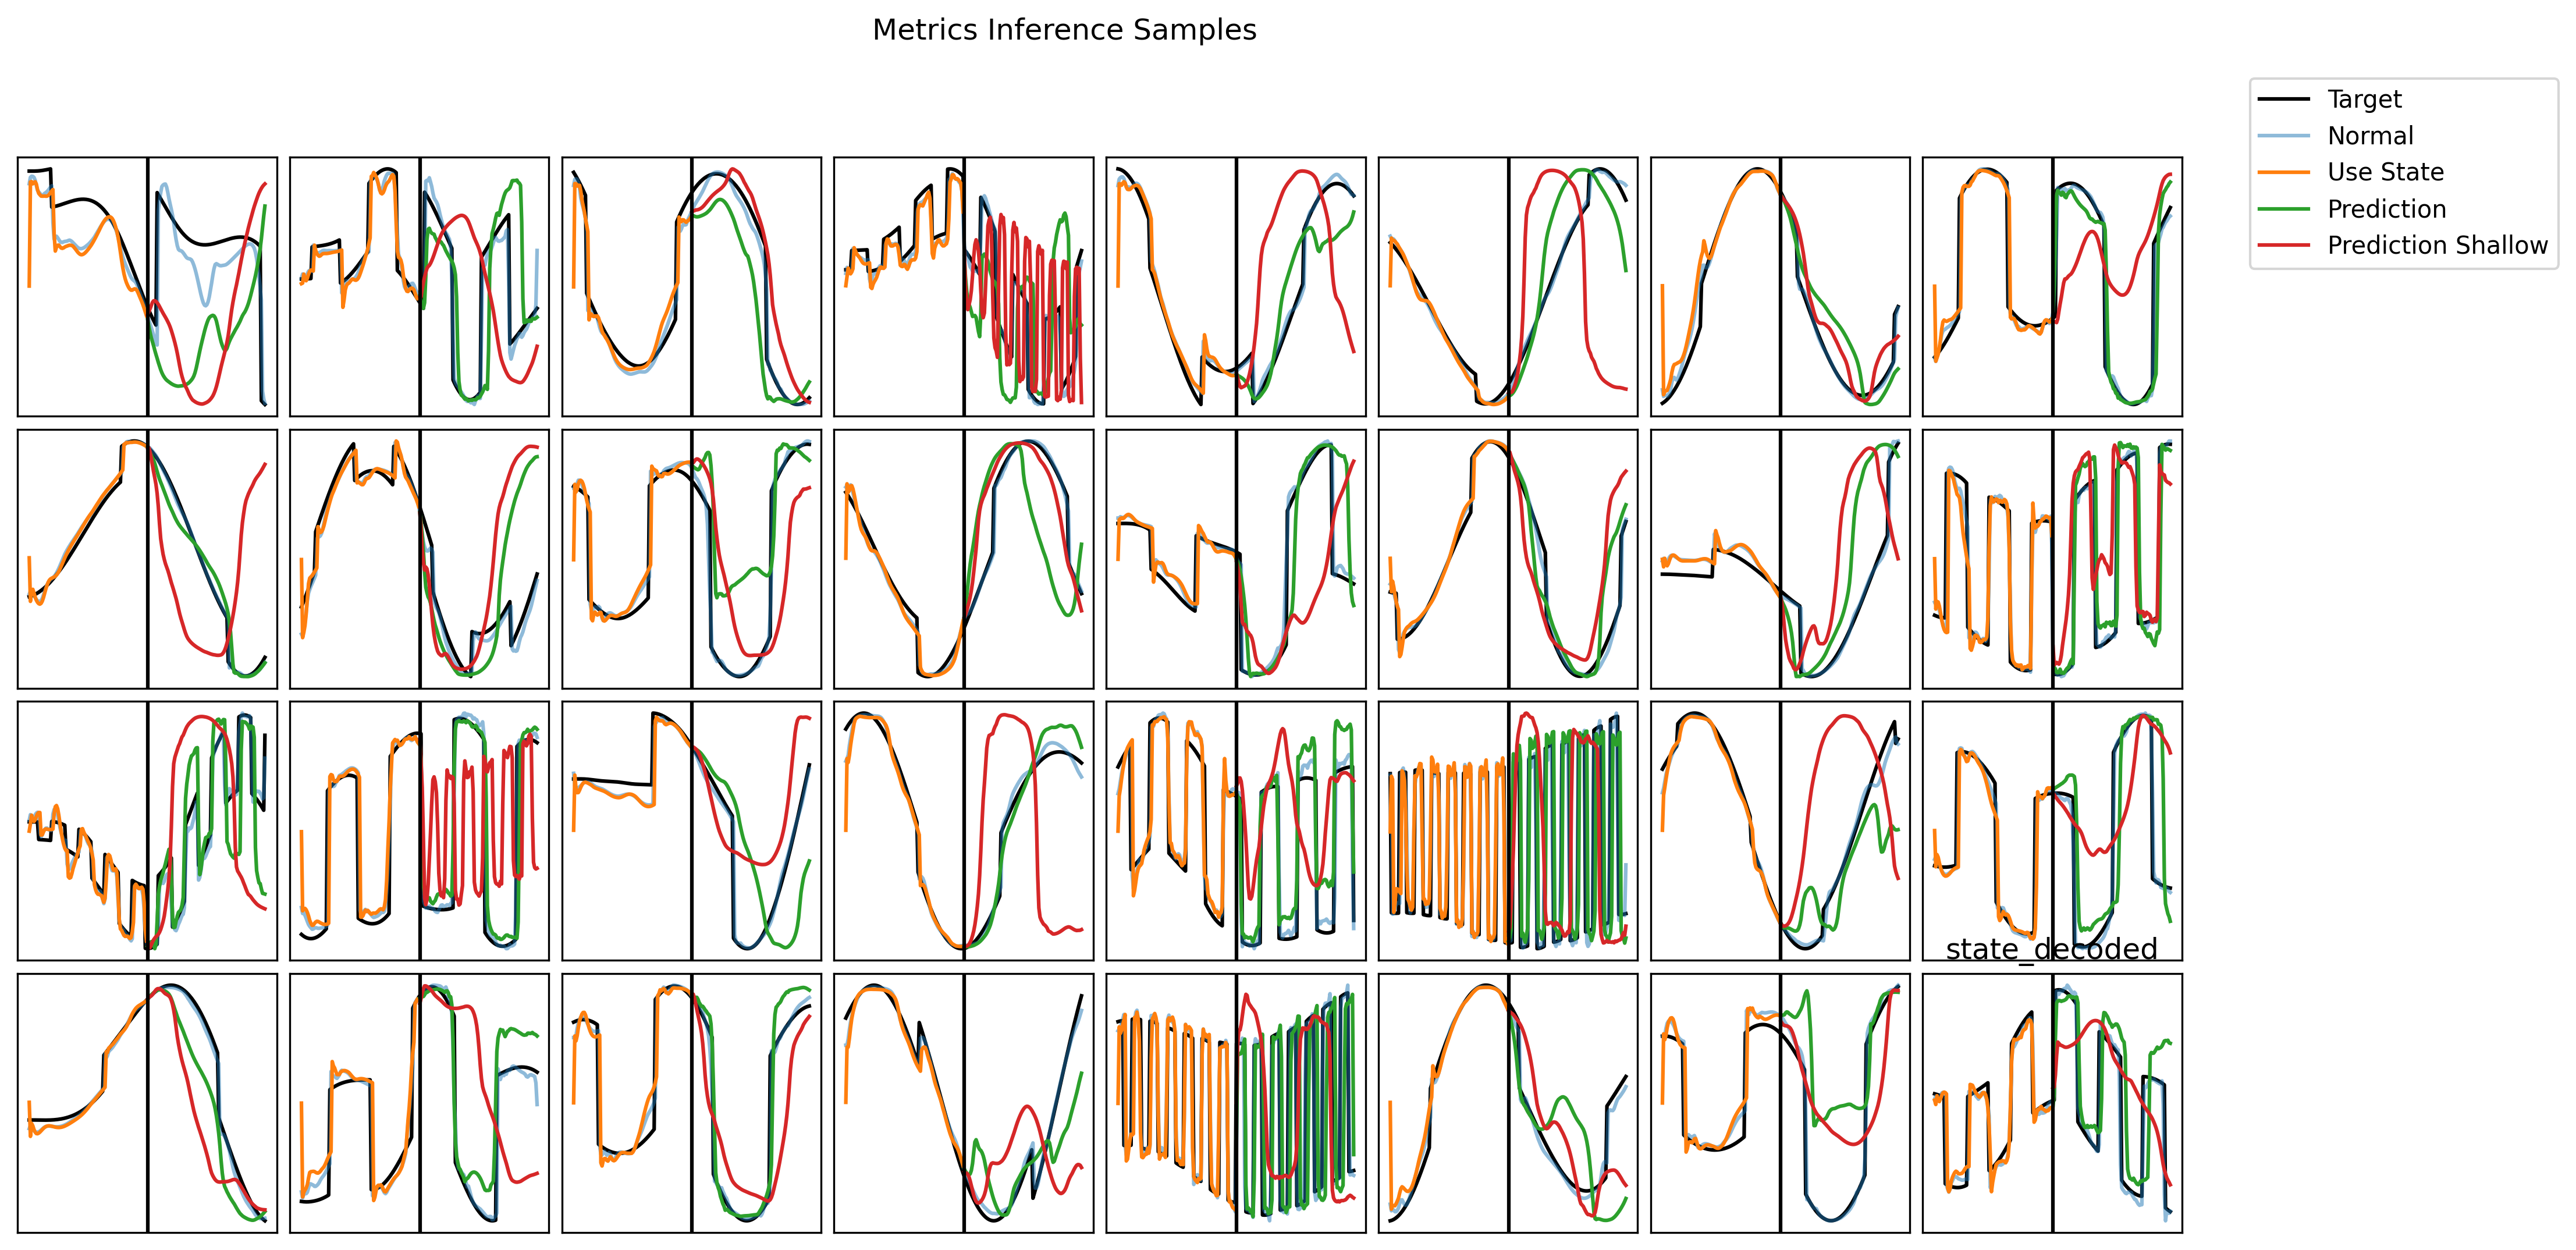

In [108]:
sample_plots = toy1d_metrics_sample_plots(sample_logits, skip_names=["state", "state_input", "state_control", "measurement"])

In [109]:
metrics = toy1d_metrics(model, dataloaders, criterion_set)

Metrics Generation: 100%|██████████| 250/250 [09:06<00:00,  2.18s/it]


In [115]:
metrics = {
        "normal": {
            "state_decoded_mse": 0.006226144731044769,
            "measurement_mse": 0.003315279958769679,
            "optimizer_loss": 0.0047707101330161095
        },
        "use_state": {
            "state_decoded_mse": 0.011700510047376156,
            "measurement_mse": 0.006857512053102255,
            "optimizer_loss": 0.009279013611376286
        },
        "prediction": {
            "state_decoded_mse": 0.04544784501194954,
            "measurement_mse": 0.029959937557578087,
            "optimizer_loss": 0.037703897804021835
        },
        "prediction_shallow": {
            "state_decoded_mse": 0.12602199614048004,
            "measurement_mse": 0.08482180535793304,
            "optimizer_loss": 0.10542188584804535
        }
    }

In [110]:
from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
orig_metrics = load_multiple_metrics("toy1d_experiments/toy1d_experiment1_configuration_test", "toy1d_metrics")

In [111]:
orig_metrics_var = orig_metrics["variation169039990650476837415612865146336274566"]

In [116]:
for task in ["normal", "use_state", "prediction", "prediction_shallow"]:
    m_task = metrics[task]["state_decoded_mse"]
    m_task_orig = orig_metrics_var["means"][task]["state_decoded_mse"]
    diff = (m_task-m_task_orig)/m_task_orig
    
    print(task, metrics[task]["state_decoded_mse"], orig_metrics_var["means"][task]["state_decoded_mse"], 100*diff, sep="|")

normal|0.006226144731044769|0.005745531525462866|8.36499118405211
use_state|0.011700510047376156|0.009278137236833572|26.108395992742256
prediction|0.04544784501194954|0.038888320326805115|16.867595797453475
prediction_shallow|0.12602199614048004|0.18497686088085175|-31.871480821780203


** FULL TRAIN - 25% Local Synched **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.006226144731044769|0.005745531525462866|8.36499118405211
use_state|0.011700510047376156|0.009278137236833572|26.108395992742256
prediction|0.04544784501194954|0.038888320326805115|16.867595797453475
prediction_shallow|0.12602199614048004|0.18497686088085175|-31.871480821780203

** Free State - 25% Local Synched - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.0050505707040429115|0.005745531525462866|-12.095675018752377
use_state|0.008438738994300365|0.009278137236833572|-9.047055687006365
prediction|0.054429881274700165|0.038888320326805115|39.964598155149666
prediction_shallow|0.1292940080165863|0.18497686088085175|-30.10260450907542

** Free State - 25% Local Synched - Free Attention - MEAN State Save **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.005373441614210606|0.005745531525462866|-6.476161685011106
use_state|0.0094678970053792|0.009278137236833572|2.0452356297586785
prediction|0.061995361000299454|0.038888320326805115|59.41897330434972
prediction_shallow|0.1695307046175003|0.18497686088085175|-8.350318082919948

** Free State - 25% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.005358148366212845|0.005745531525462866|-6.742338067996467
use_state|0.008892103098332882|0.009278137236833572|-4.1606857998194
prediction|0.0572088360786438|0.038888320326805115|47.11058641226692
prediction_shallow|0.12881498038768768|0.18497686088085175|-30.361570753078865

** Free State - 12,5% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.0049077654257416725|0.005745531525462866|-14.581176624101841
use_state|0.008334457874298096|0.009278137236833572|-10.171000260581769
prediction|0.044793665409088135|0.038888320326805115|15.185395081753011
prediction_shallow|0.14026586711406708|0.18497686088085175|-24.171127974533064



** Free State - 75% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.008892265148460865|0.005745531525462866|54.76836405913716
use_state|0.013661500066518784|0.009278137236833572|47.243996481142354
prediction|0.1157604530453682|0.038888320326805115|197.67408844751856
prediction_shallow|0.13783054053783417|0.18497686088085175|-25.487685388598795


** Free State - 50% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.00673825666308403|0.005745531525462866|17.278212350269705
use_state|0.011048161424696445|0.009278137236833572|19.07736588370344
prediction|0.07129403948783875|0.038888320326805115|83.3302104300372
prediction_shallow|0.13433396816253662|0.18497686088085175|-27.377960939090368


** Free State - 50% Local - Free Attention - Normal LR+WD**
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.007665029726922512|0.005745531525462866|33.408540062009486
use_state|0.01167269703000784|0.009278137236833572|25.80862658150849
prediction|0.10275819897651672|0.038888320326805115|164.23923201868683
prediction_shallow|0.16969460248947144|0.18497686088085175|-8.261713556283128


** Free State - 50% Local - Free Attention - State Check Local**
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.00942055881023407|0.005745531525462866|63.96322548199994
use_state|0.015547704882919788|0.009278137236833572|67.57356014520307
prediction|0.1238749548792839|0.038888320326805115|218.5402553730222
prediction_shallow|0.14469878375530243|0.18497686088085175|-21.774657075348163



** Free State - 50% Local - Freeze Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.008472094312310219|0.005745531525462866|47.45536204551063
use_state|0.017644142732024193|0.009278137236833572|90.16902080277654
prediction|0.10345781594514847|0.038888320326805115|166.0382733831695
prediction_shallow|0.13891147077083588|0.18497686088085175|-24.903325686604525

** Fixed State - Always Local - Freeze Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.027041437104344368|0.005745531525462866|370.65161829680994
use_state|0.024210166186094284|0.009278137236833572|160.9377892146451
prediction|0.1684352308511734|0.038888320326805115|333.12549741335476
prediction_shallow|0.1637730598449707|0.18497686088085175|-11.46294781677528

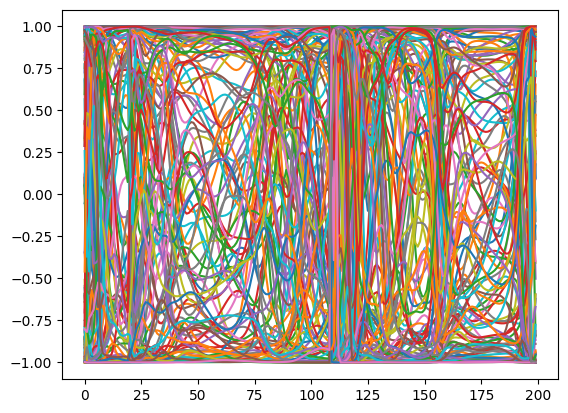

In [113]:
plt.plot(sample_logits["normal"]["state"][0])

plt.show()

(0.0, 1.0)

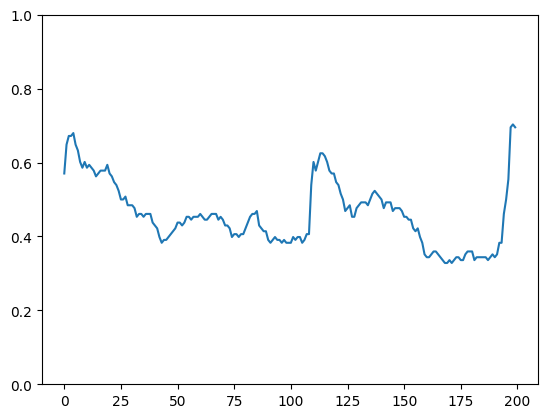

In [114]:
plt.plot((torch.abs(sample_logits["normal"]["state"][0])>0.9).sum(1)/128)

plt.ylim(0,1)